# IA340 Mini Project

**Project Title:** SEPTA Ridership by County (2014-2024)

## Research Question
Which of the counties is the county with the highest ridership and how did the ridership fluctuate when comparing the pre-pandemic period (2014–2019) to the post-pandemic period (2021–2024)?

## Dataset Documentation
- **Source:** https://catalog.data.gov/dataset/septa-ridership-statistics
- **Description:** SEPTA  ridership data (people getting On and Off a bus) categorized by county, season, and day of the week.
- **Time Period:** 2014-2024
- **Reason for Choice:** As someone who lives in a county that has SEPTA service, it's interesting to see which county utilizes this form of public transportation the most. 

In [41]:
import pandas as pd
import numpy as np
import boto3
from io import StringIO
import re 
import matplotlib.pyplot as plt
import seaborn as sns

## Import

In [42]:
septa_data = pd.read_csv('s3://ia340-2025-fall-mt-4427/Bus_Ridership_by_County.csv') 

In [43]:
septa_data.head() 

,County_Name,Mode,Season,Day_of_Week,On_,Off_,ObjectId
0,Montgomery County,Bus,Fall 2019,Saturday,14109,14995,1
1,New Castle County,Bus,Fall 2019,Saturday,152,139,2
2,Philadelphia County,Bus,Fall 2019,Saturday,202787,203013,3
3,Bucks County,Bus,Fall 2019,Sunday,2169,2240,4
4,Chester County,Bus,Fall 2019,Sunday,571,565,5


## Markdown Explanation:
- **pd.read_csv reads the data into the code to be used
- **.head() function shows the top 5 rows of the dataset

# Clean

In [44]:
septa_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   County_Name  147 non-null    object
 1   Mode         147 non-null    object
 2   Season       147 non-null    object
 3   Day_of_Week  147 non-null    object
 4   On_          147 non-null    int64 
 5   Off_         147 non-null    int64 
 6   ObjectId     147 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 8.2+ KB


In [45]:
septa_data.describe() 

,On_,Off_,ObjectId
count,147.000000,147.000000,147.000000
mean,42748.489796,42786.707483,74.000000
std,102704.991991,102419.820596,42.579338
min,0.000000,0.000000,1.000000
25%,168.000000,175.000000,37.500000
50%,3125.000000,3261.000000,74.000000
75%,22781.000000,22570.500000,110.500000
max,505004.000000,502410.000000,147.000000


In [46]:
septa_data.isnull().sum() 

County_Name    0
Mode           0
Season         0
Day_of_Week    0
On_            0
Off_           0
ObjectId       0
dtype: int64

In [47]:
septa_data.duplicated().sum()

0

In [48]:
septa_data['On_'] = pd.to_numeric(septa_data['On_'], errors='coerce')
septa_data['Off_'] = pd.to_numeric(septa_data['Off_'], errors='coerce')

septa_data['Total_Ridership'] = septa_data['On_'] + septa_data['Off_']

In [49]:
invalid_rows = septa_data[(septa_data['On_'] < 0) | (septa_data['Off_'] < 0)]
print(f"Invalid rows (negative counts): {len(invalid_rows)}")

Invalid rows (negative counts): 0


## Markdown Explanation: 
- **.info() shows the column names and basic info of the dataset
- **.describe() gives descriptive statistics of the dataset
- **.isnull().sum() checks for null values, and there were none to drop/remove from the dataset
- ** .duplicated().sum() checks for any duplicate rows in the dataset, and 0 were found
- ** the septa_data on and off, coerce forces the columns to be numeric fields
- ** the total_ridership adds the number of passengers getting on and off the bus for each row because the figures are numeric now
- ** invalid_rows checks to see if there are any invalid or negative count rows and show if there are; there are no invalid rows
## Documentation of Changes:
- ** No missing values found
- ** No duplicates found
- ** made on and off values numeric, counted them in the total ridership column
- ** checked for invalid rows(ridership counts), none were found

# Process/Aggregate

In [50]:
septa_data['Year'] = septa_data['Season'].str.extract(r'(\d{4})').astype(int)

annual_ridership = septa_data.groupby(['County_Name', 'Year'])[['On_', 'Off_', 'Total_Ridership']].sum().reset_index()

## Markdown Explanation:
- ** extracts the 4-digit year from season, combines all seasons into a single year total 

# Query

In [51]:
highest_county = annual_ridership.sort_values(by='Total_Ridership', ascending=False).head(1)
highest_county

,County_Name,Year,On_,Off_,Total_Ridership
57,Philadelphia County,2017,795487,794416,1589903


In [52]:
highest_name = highest_county['County_Name'].iloc[0]

highest_data = annual_ridership[annual_ridership['County_Name'] == highest_name]
highest_data

,County_Name,Year,On_,Off_,Total_Ridership
54,Philadelphia County,2014,505004,502410,1007414
55,Philadelphia County,2015,499884,499519,999403
56,Philadelphia County,2016,447211,447198,894409
57,Philadelphia County,2017,795487,794416,1589903
58,Philadelphia County,2018,763557,761938,1525495
59,Philadelphia County,2019,783294,784583,1567877
60,Philadelphia County,2021,373014,369729,742743
61,Philadelphia County,2022,565966,561335,1127301
62,Philadelphia County,2023,600187,596383,1196570


In [53]:
pre_period = (highest_data['Year'] >= 2014) & (highest_data['Year'] <= 2019)
post_period = (highest_data['Year'] >= 2021) & (highest_data['Year'] <= 2024)

pre_avg = highest_data[pre_period]['Total_Ridership'].mean()
post_avg = highest_data[post_period]['Total_Ridership'].mean()

print(f"County with highest ridership: {highest_name}")
print(f"Average ridership (2014–2019): {pre_avg:.0f}")
print(f"Average ridership (2021–2024): {post_avg:.0f}")
print(f"Percent change: {(post_avg - pre_avg) / pre_avg * 100:.2f}%")

County with highest ridership: Philadelphia County
Average ridership (2014–2019): 1264084
Average ridership (2021–2024): 1022205
Percent change: -19.13%


## Markdown Explanation: 
- ** sorted the dataset by annual ridership, and then revealed the first value with the head function
- ** then i stored the value of the name of the county with the highest ridership, and filtered the full dataset for just that county
- ** then i compared the average ridership for philadelphia county before and after the pandemic
- ** the results showed that there was s decline in ridership after the pandemic

# Visualizations

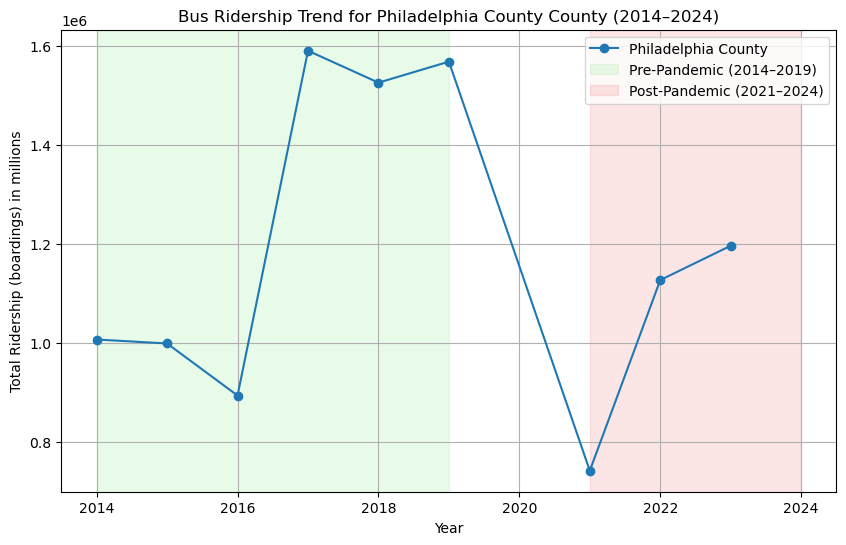

In [54]:
plt.figure(figsize=(10,6))
plt.plot(highest_data['Year'], highest_data['Total_Ridership'], marker='o', label=highest_name)

plt.axvspan(2014, 2019, color='lightgreen', alpha=0.2, label='Pre-Pandemic (2014–2019)')
plt.axvspan(2021, 2024, color='lightcoral', alpha=0.2, label='Post-Pandemic (2021–2024)')

plt.title(f"Bus Ridership Trend for {highest_name} County (2014–2024)")
plt.xlabel("Year")
plt.ylabel("Total Ridership (boardings) in millions")
plt.legend()
plt.grid(True)
plt.show()


### Markdown:
This visualization shows the total bus ridership for Philadelphia county from 2014 to 2024. The line displays the total bus ridership as it fluctuates annually. The green-shaded region shows the pre-pandemic years of bus ridership, and the red-shaded region shows the post-pandemic years. The chart shows how ridership declined during the pandemic and has been slow to climb back to pre-pandemic levels of ridership, spiking around 1.5 million in 2017 (pre-pandemic high) and re-emerging at around 1.2 million in 2023 (post-pandemic high). 

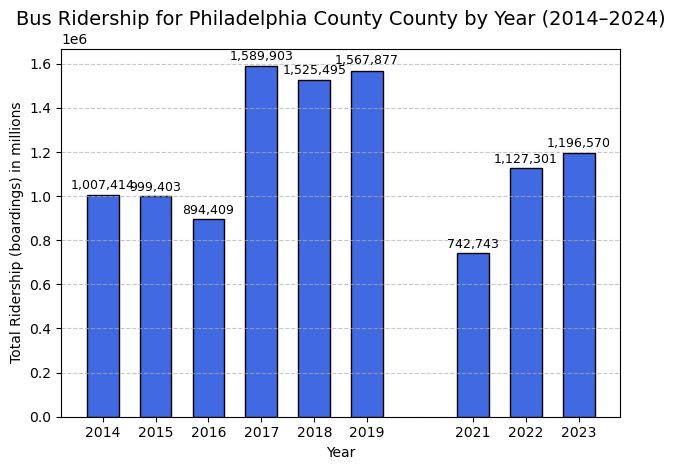

In [55]:
bars = plt.bar(highest_data['Year'], highest_data['Total_Ridership'],
               color='royalblue', edgecolor='black', width=0.6)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (height * 0.01), f'{height:,.0f}',
             ha='center', va='bottom', fontsize=9)

plt.title(f"Bus Ridership for {highest_name} County by Year (2014–2024)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Total Ridership (boardings) in millions")

plt.xticks(highest_data['Year'])
plt.grid(axis='y', linestyle='--', alpha=0.7) 
plt.tight_layout()
plt.show()

### Markdown Explanation: 
This visualization shows the annual bus ridership (data combined through earlier coding) for the highest-ridership SEPTA-serviced county (Philadelphia) from 2014-2024. The ridership rates are pretty constant in the mid-2010s, spiking and leveling out from 2017-2019. However, the ridership is negatively impacted by COVID in 2020, and the bus ridership in the 2020s so far is around the same rate as the earlier 2010s, but is nowhere near the peak in the late 2010s.  